In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the iedfinance api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
from iexfinance.stocks import get_historical_data
import iexfinance as iex

# Data Collection

In this step, you will need to use the IEX api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [5]:
list_of_tickers = ["SPY", "AGG"]

# Set start and end datetimes of 1 year, between now and 365 days ago.
end_date = datetime.now()
start_date = end_date + timedelta(-365)

# Get 1 year's worth of historical data for AAPL
historical_df = get_historical_data(list_of_tickers, start_date, end_date,  output_format='pandas')

# Drop open, high, low, volume columns
historical_df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
historical_df.head()

SPY     AGG
             close   close
date                      
2018-08-30  290.30  106.42
2018-08-31  290.31  106.41
2018-09-04  289.81  106.06
2018-09-05  289.03  106.01
2018-09-06  288.16  106.19

# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 100 iterations and generate at least 20 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 20 years

In [6]:
# Calculate the daily roi for the stocks
daily_returns_df = historical_df.pct_change()
daily_returns_df.head()

SPY       AGG
               close     close
date                          
2018-08-30       NaN       NaN
2018-08-31  0.000034 -0.000094
2018-09-04 -0.001722 -0.003289
2018-09-05 -0.002691 -0.000471
2018-09-06 -0.003010  0.001698

In [7]:
# Calculate volatility
# Use the `mean` function to calculate the mean of daily returns for `TLSA` and `SPHD`, respectively
avg_daily_return_SPY = daily_returns_df.mean()['SPY']['close']
avg_daily_return_AGG = daily_returns_df.mean()['AGG']['close']
print(f"Avg. Returns for SPY: {avg_daily_return_SPY} \nAvg. Returns for AGG: {avg_daily_return_AGG}\n")

# Use the `std` function to calculate the standard deviation of daily returns for `TSLA` and `SPHD`, respectively
std_dev_daily_return_SPY = daily_returns_df.std()['SPY']['close']
std_dev_daily_return_AGG = daily_returns_df.std()['AGG']['close']
print(f"Std. Dev for daily retuns for SPY: {std_dev_daily_return_SPY} \nStd. Dev for daily retuns for AGG: {std_dev_daily_return_AGG}")

Avg. Returns for SPY: 8.675940922672076e-05 
Avg. Returns for AGG: 0.00027800801176903177

Std. Dev for daily retuns for SPY: 0.010546086731997003 
Std. Dev for daily retuns for AGG: 0.0018463740329823825


In [8]:
# Save the last day's closing price
SPY_last_price = historical_df['SPY']['close'][-1]
AGG_last_price = historical_df['AGG']['close'][-1]
print(f"Last close price for SPY: {SPY_last_price} \nLast close price for AGG: {AGG_last_price}")


Last close price for SPY: 292.58 
Last close price for AGG: 114.03


In [9]:
# Setup the Monte Carlo Parameters
number_simulations = 500

# Project for 30 years, with 252 operating days 
number_records = 252 * 30
# Project for 2 years, with 252 operating days 
#number_records = 252 * 2

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

In [10]:
# Run the Monte Carlo Simulation
for x in range(number_simulations):
    
    # Initialize the simulated prices list with the last closing price of SPY and AGG
    simulated_SPY_prices = [SPY_last_price]
    simulated_AGG_prices = [AGG_last_price]
    
    # Simulate the returns for 252 * 20 days
    for i in range(number_records):
        
        # Calculate the simulated price using the last price within the list
        simulated_SPY_price = simulated_SPY_prices[-1] * (1 + np.random.normal(avg_daily_return_SPY, std_dev_daily_return_SPY))
        simulated_AGG_price = simulated_AGG_prices[-1] * (1 + np.random.normal(avg_daily_return_AGG, std_dev_daily_return_AGG))
        
        # Append the simulated price to the list
        simulated_SPY_prices.append(simulated_SPY_price)
        simulated_AGG_prices.append(simulated_AGG_price)
    
    # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["SPY prices"] = pd.Series(simulated_SPY_prices)
    simulated_price_df["AGG prices"] = pd.Series(simulated_AGG_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (60% SPY; 40% AGG)
    weights = [0.60, 0.40]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[x] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_cumulative_returns.head()
    
    

0         1         2         3         4         5         6    \
0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1  1.003204  0.993753  0.990616  0.998575  1.005985  1.009200  1.012314   
2  1.008608  0.998104  0.988764  0.997482  1.010062  0.996508  1.004606   
3  1.007104  0.997719  0.992979  0.989095  1.008846  1.000709  1.008989   
4  1.017903  1.000929  0.987321  0.996025  1.009880  0.993229  1.006415   

        7         8         9    ...       490       491       492       493  \
0  1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000  1.000000   
1  0.993426  1.001853  0.998765  ...  1.002174  0.994384  1.009069  0.999250   
2  0.979250  1.000328  1.009782  ...  1.004181  1.003566  1.012612  1.000670   
3  0.971269  0.999550  1.019618  ...  1.003655  1.007261  1.018348  1.001813   
4  0.967604  1.009512  1.005042  ...  1.005933  1.004057  1.015879  1.008780   

        494       495       496       497       498       499  
0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1  0.996692  1.003361  0.994263  0.990690  1.003789  0.996367  
2  0.998014  0.999589  0.993013  0.990928  1.003358  1.000575  
3  0.989047  0.997206  0.997061  0.998489  1.007190  0.998138  
4  0.996695  0.992758  0.989253  0.998695  1.012967  1.002296  

[5 rows x 500 columns]

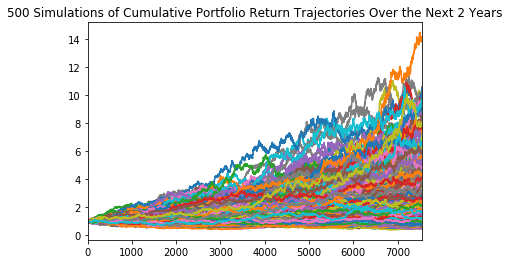

In [11]:
# Visualize the Simulation
# Use the `plot` function to plot `100` simulations of the potential trajectories of the portfolio based on 30 years
plot_title = f"{number_simulations} Simulations of Cumulative Portfolio Return Trajectories Over the Next 30 Years"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [15]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ending_cumulative_returns_30yrs = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns_30yrs.head()

0    3.579538
1    2.782209
2    4.258617
3    4.656459
4    4.007898
Name: 7560, dtype: float64

In [17]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
ending_cumulative_returns_20yrs = portfolio_cumulative_returns.iloc[-2520, :]
ending_cumulative_returns_20yrs.head()

0    1.768325
1    2.017229
2    1.451846
3    2.343277
4    2.568090
Name: 5041, dtype: float64

In [32]:
# Calculate the 90% confidence interval for the ending returns
confidence_interval = ending_cumulative_returns_30yrs.quantile(q=[0.05, 0.95])
confidence_interval

0.05    1.120475
0.95    7.042014
Name: 7560, dtype: float64

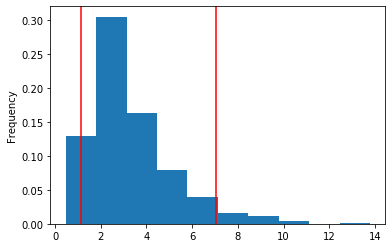

In [33]:
# # Calculate the Probability Distribution of Ending Cumulative Return Ranges
# print(ending_cumulative_returns_30yrs.value_counts(bins=10) / len(ending_cumulative_returns_30yrs))

# Visualize the distribution of the ending returns
plt.figure();
ending_cumulative_returns_30yrs.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [35]:
confidence_interval = ending_cumulative_returns_30yrs.quantile(q=[0, 0.10, .50, 0.90])
confidence_interval

0.0    0.463739
0.1    1.492467
0.5    2.838916
0.9    5.669872
Name: 7560, dtype: float64

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [41]:
initial_investment = 20000

# Calculate investment profit/loss of lower and upper bound cumulative portfolio returns
investment_expected_return_p00 = initial_investment + (initial_investment * confidence_interval.iloc[0])
investment_expected_return_p10 = initial_investment + (initial_investment * confidence_interval.iloc[1])
investment_expected_return_p50 = initial_investment + (initial_investment * confidence_interval.iloc[2])
investment_expected_return_p90 = initial_investment + (initial_investment * confidence_interval.iloc[3])
                                                    
# Print the results
print(f"On the low side, initial investment of $20,000 in the portfolio over 30 years will yeild ${round(investment_expected_return_p00)}")
print(f"There is a 10% chance that portfolio over 30 years will yeild below ${round(investment_expected_return_p10)}")
print(f"There is a 50% chance that portfolio over 30 years will yeild below ${round(investment_expected_return_p50)}")
print(f"There is a 90% chance that portfolio over 30 years will yeild below ${round(investment_expected_return_p90)}")


On the low side, initial investment of $20,000 in the portfolio over 30 years will yeild $29275.0
There is a 10% chance that portfolio over 30 years will yeild below $49849.0
There is a 50% chance that portfolio over 30 years will yeild below $76778.0
There is a 90% chance that portfolio over 30 years will yeild below $133397.0


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [46]:
projected_yearly_income_before_tax = 7389
retirement_withdrawal_rate = .04
if (retirement_withdrawal_rate * investment_expected_return_p10 > projected_yearly_income_before_tax):
    print("Expected portfolio return at 10th percentile will exceed projected yearly income")
else:
    print("Expected portfolio return at 10th percentile will not exceed projected yearly income")

Expected portfolio return at 10th percentile will not exceed projected yearly income


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [44]:
increase_investment_pct = .5
new_initial_investment = initial_investment * (1 + increase_investment_pct)
new_investment_expected_return_p10 = new_initial_investment + (new_initial_investment * confidence_interval.iloc[1])

if (retirement_withdrawal_rate * new_investment_expected_return_p10 > projected_yearly_income_before_tax):
    print("Expected portfolio return at 10th percentile will exceed projected yearly income")
else:
    print("Expected portfolio return at 10th percentile will not exceed projected yearly income")

Expected portfolio return at 10th percentile will not exceed projected yearly income


### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [ ]:
# YOUR CODE HERE